# Noise-Aware Demo
Run the next cell to train the noise-aware qnn moons model (T1=80 µs, T2=120 µs) and plot loss/accuracy.

MOONS | NOISE_AWARE | Epoch 01 | Loss 1.2864 | Acc 0.507
MOONS | NOISE_AWARE | Epoch 02 | Loss 1.1830 | Acc 0.533
MOONS | NOISE_AWARE | Epoch 03 | Loss 1.0872 | Acc 0.547
MOONS | NOISE_AWARE | Epoch 04 | Loss 1.0001 | Acc 0.573
MOONS | NOISE_AWARE | Epoch 05 | Loss 0.9226 | Acc 0.600
MOONS | NOISE_AWARE | Epoch 06 | Loss 0.8547 | Acc 0.653
MOONS | NOISE_AWARE | Epoch 07 | Loss 0.7960 | Acc 0.693
MOONS | NOISE_AWARE | Epoch 08 | Loss 0.7459 | Acc 0.740
MOONS | NOISE_AWARE | Epoch 09 | Loss 0.7037 | Acc 0.760
MOONS | NOISE_AWARE | Epoch 10 | Loss 0.6684 | Acc 0.773


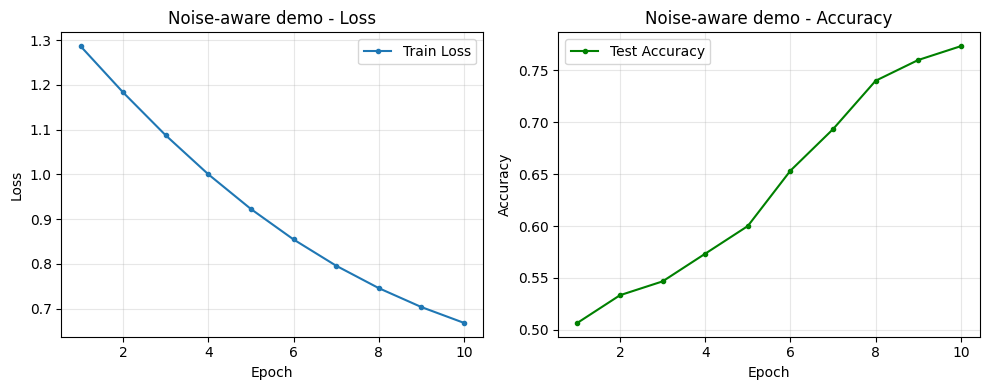

In [2]:
import sys
sys.path.insert(0, '..')

# Minimal noise-aware run + plot
from qml_training import train, EncodingType
from visualizer import plot_training_curves

# Small demo run (moons, 10 epochs) with T1/T2 noise
metrics = train(
    model_type="noise_aware",
    encoding=EncodingType.ANGLE,
    dataset="moons",
    epochs=10,
    record_metrics=True,
    T1=80.0,
    T2=120.0,
)

plot_training_curves(
    metrics["loss_history"],
    metrics["acc_history"],
    dataset="moons",
    model_type="noise_aware",
    title="Noise-aware demo",
    save=False,
    T1=80.0,
    T2=120.0,
    epochs=3,
)


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, Circle, FancyArrowPatch
import math

# Import our quantum simulator components
from quantum_simulator import (
    zero_state, custom_state, apply_gate, apply_circuit_to_ket,
    state_to_density, run_noisy_circuit_density, measure,
    RY, RZ, RX, CNOT, H, X, Z, I2
)
from qml_training import (
    EncodingType, state_encoding, quantum_feature_map,
    param_gate_layer
)
from error_kraus import thermal_relaxation_error_rate, add_time_based_noise

print("✅ All imports successful!")

✅ All imports successful!


## Circuit Visualization Helpers

Custom visualization functions to draw quantum circuits in a clean, readable format.

In [4]:
def draw_circuit(circuit, num_qubits, title="Quantum Circuit", figsize=(12, 3)):
    """
    Draw a quantum circuit diagram.
    
    circuit: List of (gate_name, [qubits], param?) tuples
    num_qubits: Number of qubits
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Layout parameters
    wire_spacing = 1.0
    gate_width = 0.6
    gate_spacing = 1.2
    start_x = 1.0
    
    # Draw qubit wires
    max_x = start_x + len(circuit) * gate_spacing + 1
    for q in range(num_qubits):
        y = (num_qubits - 1 - q) * wire_spacing
        ax.hlines(y, 0, max_x, colors='black', linewidth=1)
        ax.text(-0.3, y, f'q{q}', fontsize=12, ha='right', va='center', fontweight='bold')
    
    # Gate colors
    gate_colors = {
        'RY': '#4CAF50',  # Green
        'RZ': '#2196F3',  # Blue
        'RX': '#FF9800',  # Orange
        'H': '#9C27B0',   # Purple
        'X': '#E91E63',   # Pink
        'CNOT': '#607D8B', # Gray
        'T1T2_NOISE': '#F44336',  # Red for noise
    }
    
    # Draw gates
    for i, op in enumerate(circuit):
        x = start_x + i * gate_spacing
        gate_name = op[0]
        qubits = op[1]
        param = op[2] if len(op) > 2 else None
        
        color = gate_colors.get(gate_name, '#9E9E9E')
        
        if gate_name == 'CNOT':
            # Draw CNOT gate
            ctrl_y = (num_qubits - 1 - qubits[0]) * wire_spacing
            targ_y = (num_qubits - 1 - qubits[1]) * wire_spacing
            
            # Control dot
            ax.plot(x, ctrl_y, 'ko', markersize=10)
            # Vertical line
            ax.vlines(x, min(ctrl_y, targ_y), max(ctrl_y, targ_y), colors='black', linewidth=2)
            # Target circle with X
            circle = plt.Circle((x, targ_y), 0.2, fill=False, linewidth=2, color='black')
            ax.add_patch(circle)
            ax.vlines(x, targ_y - 0.2, targ_y + 0.2, colors='black', linewidth=2)
            ax.hlines(targ_y, x - 0.2, x + 0.2, colors='black', linewidth=2)
            
        elif gate_name == 'T1T2_NOISE':
            # Draw noise operator (wavy box) with λ1, λ2, and time info
            λ1 = op[2] if len(op) > 2 else 0
            λ2 = op[3] if len(op) > 3 else 0
            idle_time = op[4] if len(op) > 4 else 0
            for q in qubits:
                y = (num_qubits - 1 - q) * wire_spacing
                # Make box wider to fit text
                noise_width = gate_width * 1.8
                rect = FancyBboxPatch(
                    (x - noise_width/2, y - 0.35), noise_width, 0.7,
                    boxstyle="round,pad=0.05", facecolor=color, edgecolor='darkred',
                    linewidth=2, alpha=0.8, linestyle='--'
                )
                ax.add_patch(rect)
                # Display noise parameters: λ1, λ2, and time
                noise_label = f"λ₁={λ1:.3f}\nλ₂={λ2:.3f}\nt={idle_time:.1f}"
                ax.text(x, y, noise_label, fontsize=6, ha='center', va='center', 
                        color='white', fontweight='bold')
        else:
            # Draw single/multi-qubit gate box
            for q in qubits:
                y = (num_qubits - 1 - q) * wire_spacing
                rect = FancyBboxPatch(
                    (x - gate_width/2, y - 0.3), gate_width, 0.6,
                    boxstyle="round,pad=0.05", facecolor=color, edgecolor='black',
                    linewidth=1.5
                )
                ax.add_patch(rect)
                
                # Gate label
                label = gate_name
                if param is not None:
                    if isinstance(param, (int, float)):
                        label = f"{gate_name}\n({param:.2f})"
                    elif isinstance(param, torch.Tensor):
                        label = f"{gate_name}\n({param.item():.2f})"
                ax.text(x, y, label, fontsize=8, ha='center', va='center', 
                        color='white', fontweight='bold')
    
    ax.set_xlim(-0.5, max_x)
    ax.set_ylim(-0.5, num_qubits * wire_spacing)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
    
    plt.tight_layout()
    return fig, ax

print("✅ Visualization helpers loaded!")

✅ Visualization helpers loaded!


---
## 1. State Encoding Methods

We support two encoding types:
- **Angle Encoding**: Each feature maps to a rotation angle on a qubit (RY gate)
- **Amplitude Encoding**: Features are encoded directly as state amplitudes

=== ANGLE ENCODING ===
Input features: [0.5, -0.800000011920929]

Circuit operations:
  ('RY', [0], tensor(0.5000))
  ('RY', [1], tensor(-0.8000))


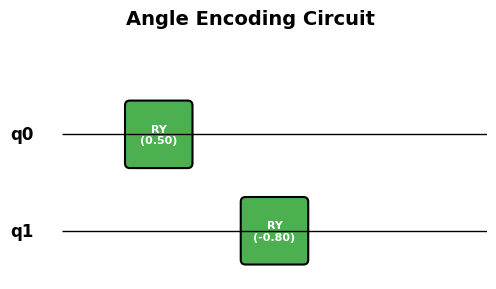

In [5]:
# Example: Angle Encoding for 2 qubits
n_qubits = 2
x_angle = torch.tensor([0.5, -0.8])  # Two features → two qubits

# Get the encoding circuit
state_angle, circuit_angle = state_encoding(x_angle, n_qubits, encoding=EncodingType.ANGLE)

print("=== ANGLE ENCODING ===")
print(f"Input features: {x_angle.tolist()}")
print(f"\nCircuit operations:")
for op in circuit_angle:
    print(f"  {op}")

# Visualize
draw_circuit(circuit_angle, n_qubits, title="Angle Encoding Circuit")
plt.show()

=== AMPLITUDE ENCODING ===
Input features: [0.5, 0.30000001192092896, 0.699999988079071, 0.20000000298023224]

Initial state (normalized amplitudes):
  |ψ⟩ = [0.5360563 +0.j 0.3216338 +0.j 0.7504788 +0.j 0.21442251+0.j]

Circuit operations: None (state preparation only)


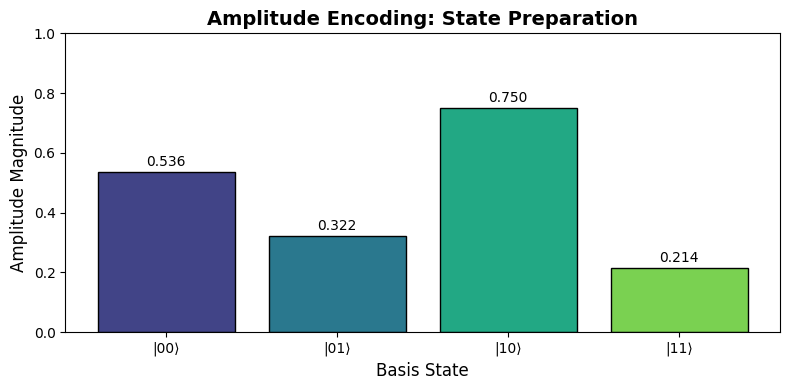

In [6]:
# Example: Amplitude Encoding for 2 qubits
# Need 2^2 = 4 amplitudes for 2 qubits
x_amplitude = torch.tensor([0.5, 0.3, 0.7, 0.2])

state_amp, circuit_amp = state_encoding(x_amplitude, n_qubits, encoding=EncodingType.AMPLITUDE)

print("=== AMPLITUDE ENCODING ===")
print(f"Input features: {x_amplitude.tolist()}")
print(f"\nInitial state (normalized amplitudes):")
print(f"  |ψ⟩ = {state_amp.numpy()}")
print(f"\nCircuit operations: {circuit_amp if circuit_amp else 'None (state preparation only)'}")

# Visualize state as bar chart
fig, ax = plt.subplots(figsize=(8, 4))
basis_labels = ['|00⟩', '|01⟩', '|10⟩', '|11⟩']
amplitudes = torch.abs(state_amp).numpy()
colors = plt.cm.viridis(np.linspace(0.2, 0.8, 4))
ax.bar(basis_labels, amplitudes, color=colors, edgecolor='black')
ax.set_ylabel('Amplitude Magnitude', fontsize=12)
ax.set_xlabel('Basis State', fontsize=12)
ax.set_title('Amplitude Encoding: State Preparation', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1)
for i, v in enumerate(amplitudes):
    ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=10)
plt.tight_layout()
plt.show()

### Encoding Comparison: Measurement Distributions

Let's compare how the same data looks under different encodings.

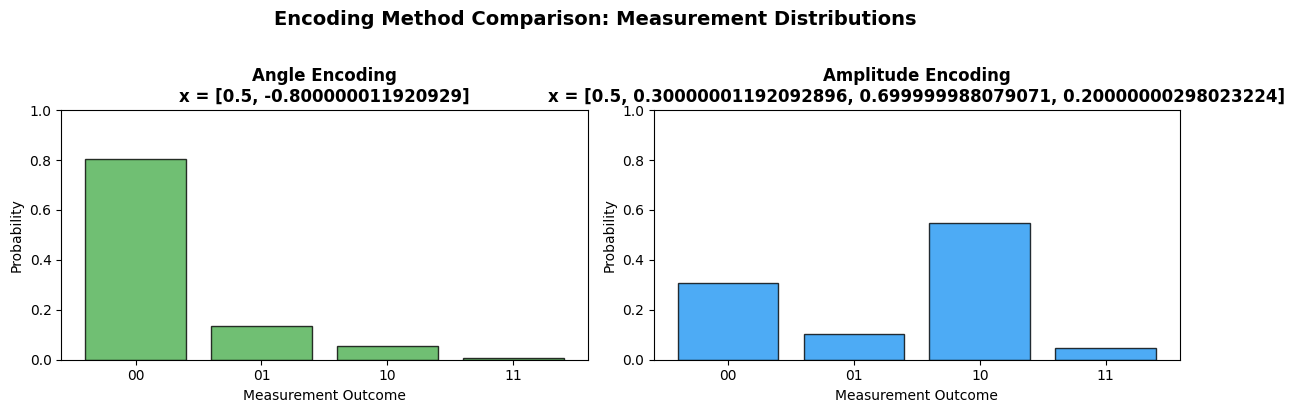

In [7]:
# Apply the circuits and measure
SHOTS = 2000

# Angle encoding: apply the RY circuit
final_state_angle = apply_circuit_to_ket(state_angle, circuit_angle, n_qubits)
counts_angle = measure(final_state_angle, shots=SHOTS)

# Amplitude encoding: state is already prepared
counts_amp = measure(state_amp, shots=SHOTS)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

basis_labels = ['00', '01', '10', '11']

# Angle encoding
ax = axes[0]
values = [counts_angle.get(b, 0) / SHOTS for b in basis_labels]
ax.bar(basis_labels, values, color='#4CAF50', edgecolor='black', alpha=0.8)
ax.set_title(f'Angle Encoding\nx = {x_angle.tolist()}', fontsize=12, fontweight='bold')
ax.set_ylabel('Probability')
ax.set_xlabel('Measurement Outcome')
ax.set_ylim(0, 1)

# Amplitude encoding
ax = axes[1]
values = [counts_amp.get(b, 0) / SHOTS for b in basis_labels]
ax.bar(basis_labels, values, color='#2196F3', edgecolor='black', alpha=0.8)
ax.set_title(f'Amplitude Encoding\nx = {x_amplitude.tolist()}', fontsize=12, fontweight='bold')
ax.set_ylabel('Probability')
ax.set_xlabel('Measurement Outcome')
ax.set_ylim(0, 1)

plt.suptitle('Encoding Method Comparison: Measurement Distributions', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 2. Quantum Kernel Feature Map

The quantum kernel uses a feature map that includes:
1. State encoding (RY gates for angle encoding)
2. Entanglement layer (CNOT)

=== QUANTUM KERNEL FEATURE MAP ===
Input: x = [0.699999988079071, -0.30000001192092896]

Circuit structure:
  Layer 1: ('RY', [0], tensor(0.7000))
  Layer 2: ('RY', [1], tensor(-0.3000))
  Layer 3: ('CNOT', [0, 1])


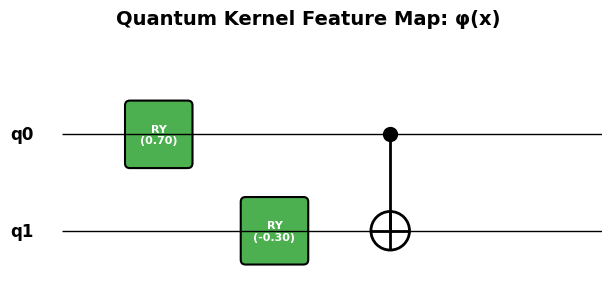

In [8]:
# Build the quantum kernel feature map circuit
x_kernel = torch.tensor([0.7, -0.3])

# The feature map: RY encoding + CNOT entanglement
kernel_circuit = param_gate_layer("RY", x_kernel)  # Encoding layer
kernel_circuit += [("CNOT", [0, 1])]  # Entanglement

print("=== QUANTUM KERNEL FEATURE MAP ===")
print(f"Input: x = {x_kernel.tolist()}")
print(f"\nCircuit structure:")
for i, op in enumerate(kernel_circuit):
    print(f"  Layer {i+1}: {op}")

draw_circuit(kernel_circuit, n_qubits, title="Quantum Kernel Feature Map: φ(x)")
plt.show()

=== QUANTUM KERNEL VALUES ===
k(x₁, x₁) = 1.0000  (self-similarity, should be ~1.0)
k(x₁, x₂) = 0.9969  (similar points)
k(x₁, x₃) = 0.4881  (different points)


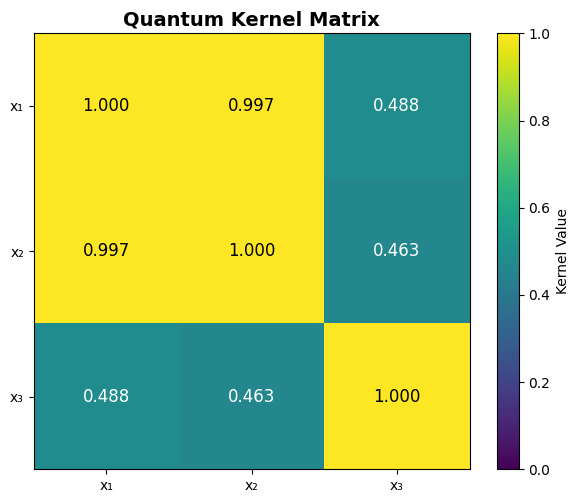

In [9]:
# Compute kernel value between two data points
from qml_training import quantum_kernel

x1 = torch.tensor([0.5, 0.3])
x2 = torch.tensor([0.6, 0.25])
x3 = torch.tensor([-0.8, -0.7])

k_11 = quantum_kernel(x1, x1)
k_12 = quantum_kernel(x1, x2)
k_13 = quantum_kernel(x1, x3)

print("=== QUANTUM KERNEL VALUES ===")
print(f"k(x₁, x₁) = {k_11:.4f}  (self-similarity, should be ~1.0)")
print(f"k(x₁, x₂) = {k_12:.4f}  (similar points)")
print(f"k(x₁, x₃) = {k_13:.4f}  (different points)")

# Visualize as heatmap
points = [x1, x2, x3]
labels = ['x₁', 'x₂', 'x₃']
K = torch.zeros(3, 3)
for i in range(3):
    for j in range(3):
        K[i, j] = quantum_kernel(points[i], points[j])

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(K.numpy(), cmap='viridis', vmin=0, vmax=1)
ax.set_xticks(range(3))
ax.set_yticks(range(3))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

for i in range(3):
    for j in range(3):
        ax.text(j, i, f'{K[i,j]:.3f}', ha='center', va='center', 
                color='white' if K[i,j] < 0.7 else 'black', fontsize=12)

ax.set_title('Quantum Kernel Matrix', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax, label='Kernel Value')
plt.tight_layout()
plt.show()

---
## 3. Noise Effects: T1/T2 Thermal Relaxation

Our simulator models realistic quantum hardware noise using:
- **T1 (Amplitude Damping)**: Energy relaxation, |1⟩ → |0⟩ decay
- **T2 (Phase Damping)**: Dephasing, loss of quantum coherence

Let's visualize how circuits change when noise is added.

=== ORIGINAL CIRCUIT (No Noise) ===
  ('RY', [0], 0.5)
  ('RY', [1], -0.3)
  ('CNOT', [0, 1])
  ('RZ', [0], 0.7)


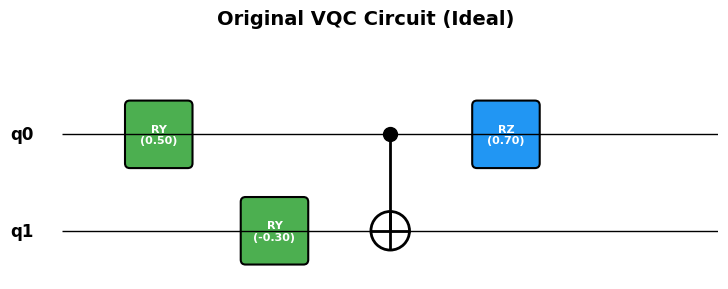

In [10]:
# Define a simple VQC circuit
vqc_circuit = [
    ("RY", [0], 0.5),
    ("RY", [1], -0.3),
    ("CNOT", [0, 1]),
    ("RZ", [0], 0.7),
]

gate_durations = {
    "RY": 1,
    "RZ": 1,
    "CNOT": 2,  # Two-qubit gates typically take longer
}

print("=== ORIGINAL CIRCUIT (No Noise) ===")
for op in vqc_circuit:
    print(f"  {op}")

draw_circuit(vqc_circuit, n_qubits, title="Original VQC Circuit (Ideal)")
plt.show()

=== NOISY CIRCUIT (T1=100μs, T2=200μs) ===
  T1T2_NOISE on q0: λ1=0.0100, λ2=0.000000, idle=1.0μs
  ('RY', [0], 0.5)
  T1T2_NOISE on q1: λ1=0.0100, λ2=0.000000, idle=1.0μs
  ('RY', [1], -0.3)
  T1T2_NOISE on q0: λ1=0.0198, λ2=0.000000, idle=2.0μs
  T1T2_NOISE on q1: λ1=0.0198, λ2=0.000000, idle=2.0μs
  ('CNOT', [0, 1])
  T1T2_NOISE on q0: λ1=0.0100, λ2=0.000000, idle=1.0μs
  ('RZ', [0], 0.7)
  T1T2_NOISE on q1: λ1=0.0100, λ2=0.000000, idle=1.0μs


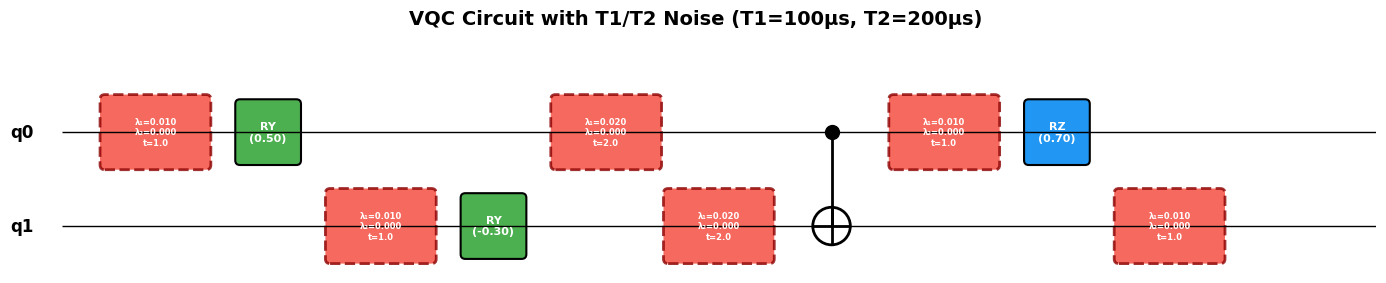

In [11]:
# Add T1/T2 noise to the circuit
T1 = 100  # microseconds (typical for superconducting qubits)
T2 = 200

noisy_circuit = add_time_based_noise(
    circuit=vqc_circuit,
    num_qubits=n_qubits,
    T1=T1,
    T2=T2,
    gate_durations=gate_durations
)

print(f"=== NOISY CIRCUIT (T1={T1}μs, T2={T2}μs) ===")
for op in noisy_circuit:
    if op[0] == 'T1T2_NOISE':
        print(f"  {op[0]} on q{op[1][0]}: λ1={op[2]:.4f}, λ2={op[3]:.6f}, idle={op[4]:.1f}μs")
    else:
        print(f"  {op}")

draw_circuit(noisy_circuit, n_qubits, 
             title=f"VQC Circuit with T1/T2 Noise (T1={T1}μs, T2={T2}μs)",
             figsize=(14, 3))
plt.show()

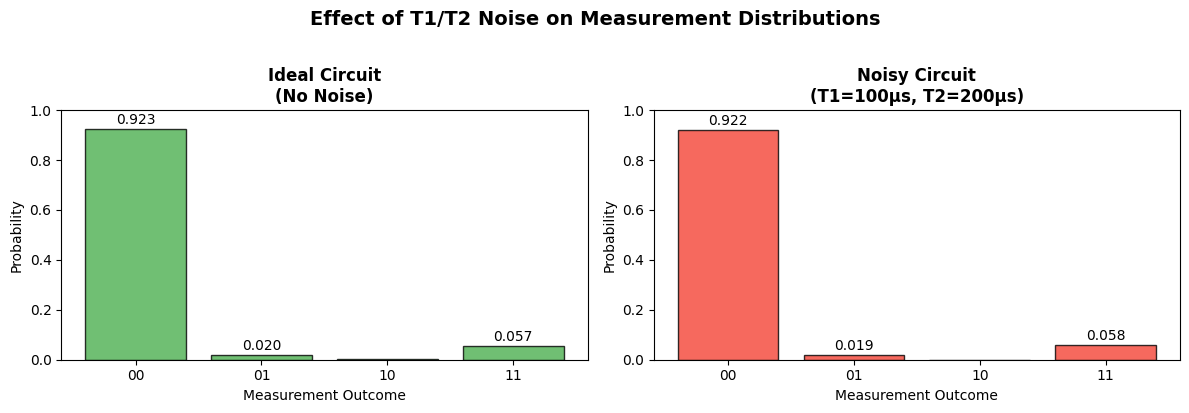

In [12]:
# Compare measurement outcomes: Ideal vs Noisy
SHOTS = 5000

# Ideal execution
init_state = zero_state(n_qubits)
ideal_state = apply_circuit_to_ket(init_state, vqc_circuit, n_qubits)
ideal_counts = measure(ideal_state, shots=SHOTS)

# Noisy execution (using density matrix)
noisy_density = run_noisy_circuit_density(
    initial_state=init_state,
    circuit=vqc_circuit,
    num_qubits=n_qubits,
    T1=T1,
    T2=T2,
    gate_durations=gate_durations
)

# Sample from noisy density matrix
probs_noisy = torch.real(torch.diag(noisy_density)).numpy()
probs_noisy = np.maximum(probs_noisy, 0)  # Ensure non-negative
probs_noisy = probs_noisy / probs_noisy.sum()  # Normalize

noisy_counts = {}
outcomes = np.random.choice(4, size=SHOTS, p=probs_noisy)
for o in outcomes:
    bitstr = format(o, '02b')
    noisy_counts[bitstr] = noisy_counts.get(bitstr, 0) + 1

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
basis_labels = ['00', '01', '10', '11']

# Ideal
ax = axes[0]
values = [ideal_counts.get(b, 0) / SHOTS for b in basis_labels]
ax.bar(basis_labels, values, color='#4CAF50', edgecolor='black', alpha=0.8)
ax.set_title('Ideal Circuit\n(No Noise)', fontsize=12, fontweight='bold')
ax.set_ylabel('Probability')
ax.set_xlabel('Measurement Outcome')
ax.set_ylim(0, 1)
for i, v in enumerate(values):
    if v > 0.01:
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=10)

# Noisy
ax = axes[1]
values = [noisy_counts.get(b, 0) / SHOTS for b in basis_labels]
ax.bar(basis_labels, values, color='#F44336', edgecolor='black', alpha=0.8)
ax.set_title(f'Noisy Circuit\n(T1={T1}μs, T2={T2}μs)', fontsize=12, fontweight='bold')
ax.set_ylabel('Probability')
ax.set_xlabel('Measurement Outcome')
ax.set_ylim(0, 1)
for i, v in enumerate(values):
    if v > 0.01:
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=10)

plt.suptitle('Effect of T1/T2 Noise on Measurement Distributions', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

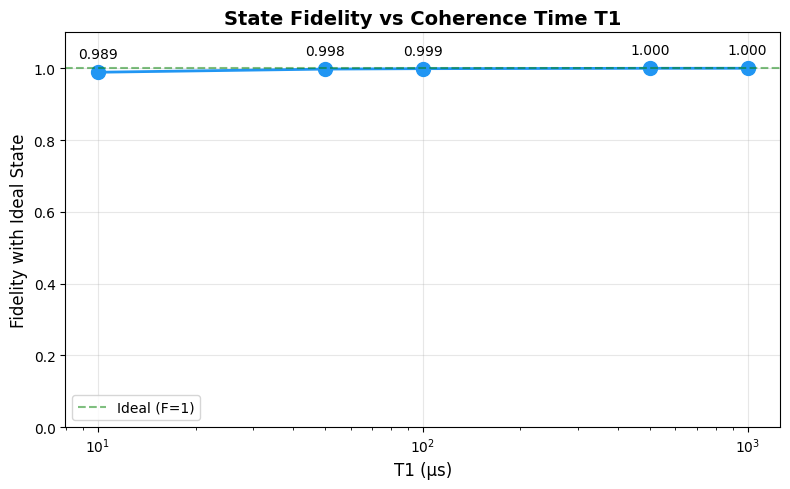


=== FIDELITY SUMMARY ===
T1=  10μs, T2=  20μs → Fidelity = 0.9888
T1=  50μs, T2= 100μs → Fidelity = 0.9976
T1= 100μs, T2= 200μs → Fidelity = 0.9988
T1= 500μs, T2=1000μs → Fidelity = 0.9998
T1=1000μs, T2=2000μs → Fidelity = 0.9999


In [13]:
# Sweep over different noise levels
T1_values = [10, 50, 100, 500, 1000]  # Different T1 times
fidelities = []

for T1 in T1_values:
    T2 = 2 * T1  # T2 is typically ≤ 2*T1
    
    noisy_density = run_noisy_circuit_density(
        initial_state=init_state,
        circuit=vqc_circuit,
        num_qubits=n_qubits,
        T1=T1,
        T2=T2,
        gate_durations=gate_durations
    )
    
    # Calculate fidelity with ideal state
    ideal_density = state_to_density(ideal_state)
    fidelity = torch.real(torch.trace(ideal_density @ noisy_density)).item()
    fidelities.append(fidelity)

# Plot fidelity vs T1
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(T1_values, fidelities, 'o-', markersize=10, linewidth=2, color='#2196F3')
ax.axhline(y=1.0, color='green', linestyle='--', alpha=0.5, label='Ideal (F=1)')
ax.set_xlabel('T1 (μs)', fontsize=12)
ax.set_ylabel('Fidelity with Ideal State', fontsize=12)
ax.set_title('State Fidelity vs Coherence Time T1', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.set_ylim(0, 1.1)
ax.grid(True, alpha=0.3)
ax.legend()

for x, y in zip(T1_values, fidelities):
    ax.annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

plt.tight_layout()
plt.show()

print("\n=== FIDELITY SUMMARY ===")
for t1, f in zip(T1_values, fidelities):
    print(f"T1={t1:4d}μs, T2={2*t1:4d}μs → Fidelity = {f:.4f}")

---
## 4. Deep VQC Architecture

Our deep variational quantum circuit uses multiple layers of parameterized gates.

=== DEEP VQC (3 layers) ===
Total gates: 14
Trainable parameters: 9


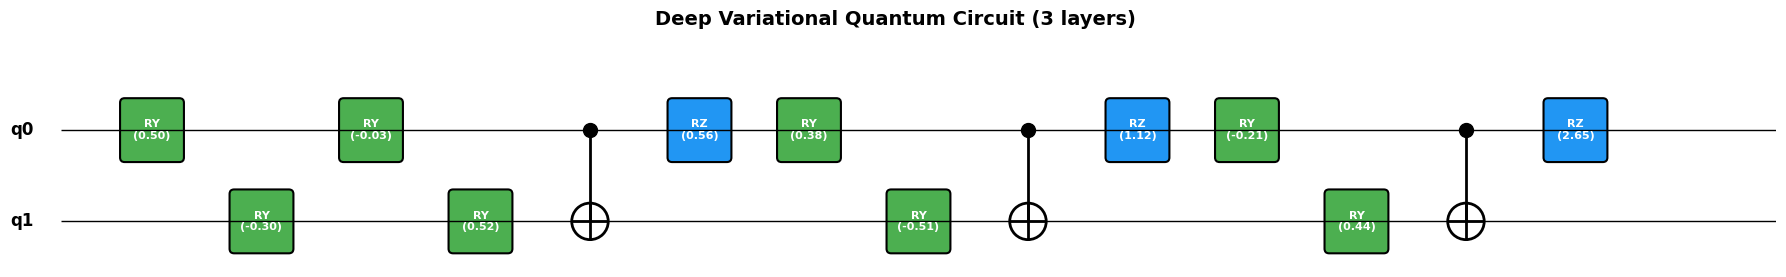

In [14]:
# Build a 3-layer deep VQC circuit
depth = 3
x_input = torch.tensor([0.5, -0.3])
theta = torch.randn(depth * 3)  # 3 parameters per layer

# Construct the full circuit
deep_vqc = []

# Encoding layer
deep_vqc += param_gate_layer("RY", x_input)

# Variational layers
idx = 0
for layer in range(depth):
    deep_vqc.append(("RY", [0], theta[idx].item()))
    deep_vqc.append(("RY", [1], theta[idx+1].item()))
    deep_vqc.append(("CNOT", [0, 1]))
    deep_vqc.append(("RZ", [0], theta[idx+2].item()))
    idx += 3

print(f"=== DEEP VQC ({depth} layers) ===")
print(f"Total gates: {len(deep_vqc)}")
print(f"Trainable parameters: {len(theta)}")

draw_circuit(deep_vqc, n_qubits, 
             title=f"Deep Variational Quantum Circuit ({depth} layers)",
             figsize=(18, 3))
plt.show()

---
## Summary

This demo covered:

| Component | Description |
|-----------|-------------|
| **Angle Encoding** | Maps N features to N qubits via RY rotations |
| **Amplitude Encoding** | Maps 2^N amplitudes directly to N qubit state |
| **Quantum Kernel** | Uses feature map + inner product for similarity |
| **T1/T2 Noise** | Models thermal relaxation in real quantum hardware |
| **Deep VQC** | Multi-layer variational circuit for classification |

The noise model shows how hardware imperfections degrade quantum state fidelity, motivating our noise-aware training approach.